In [4]:
#Imports:
import numpy as np
import matplotlib.pyplot as plt


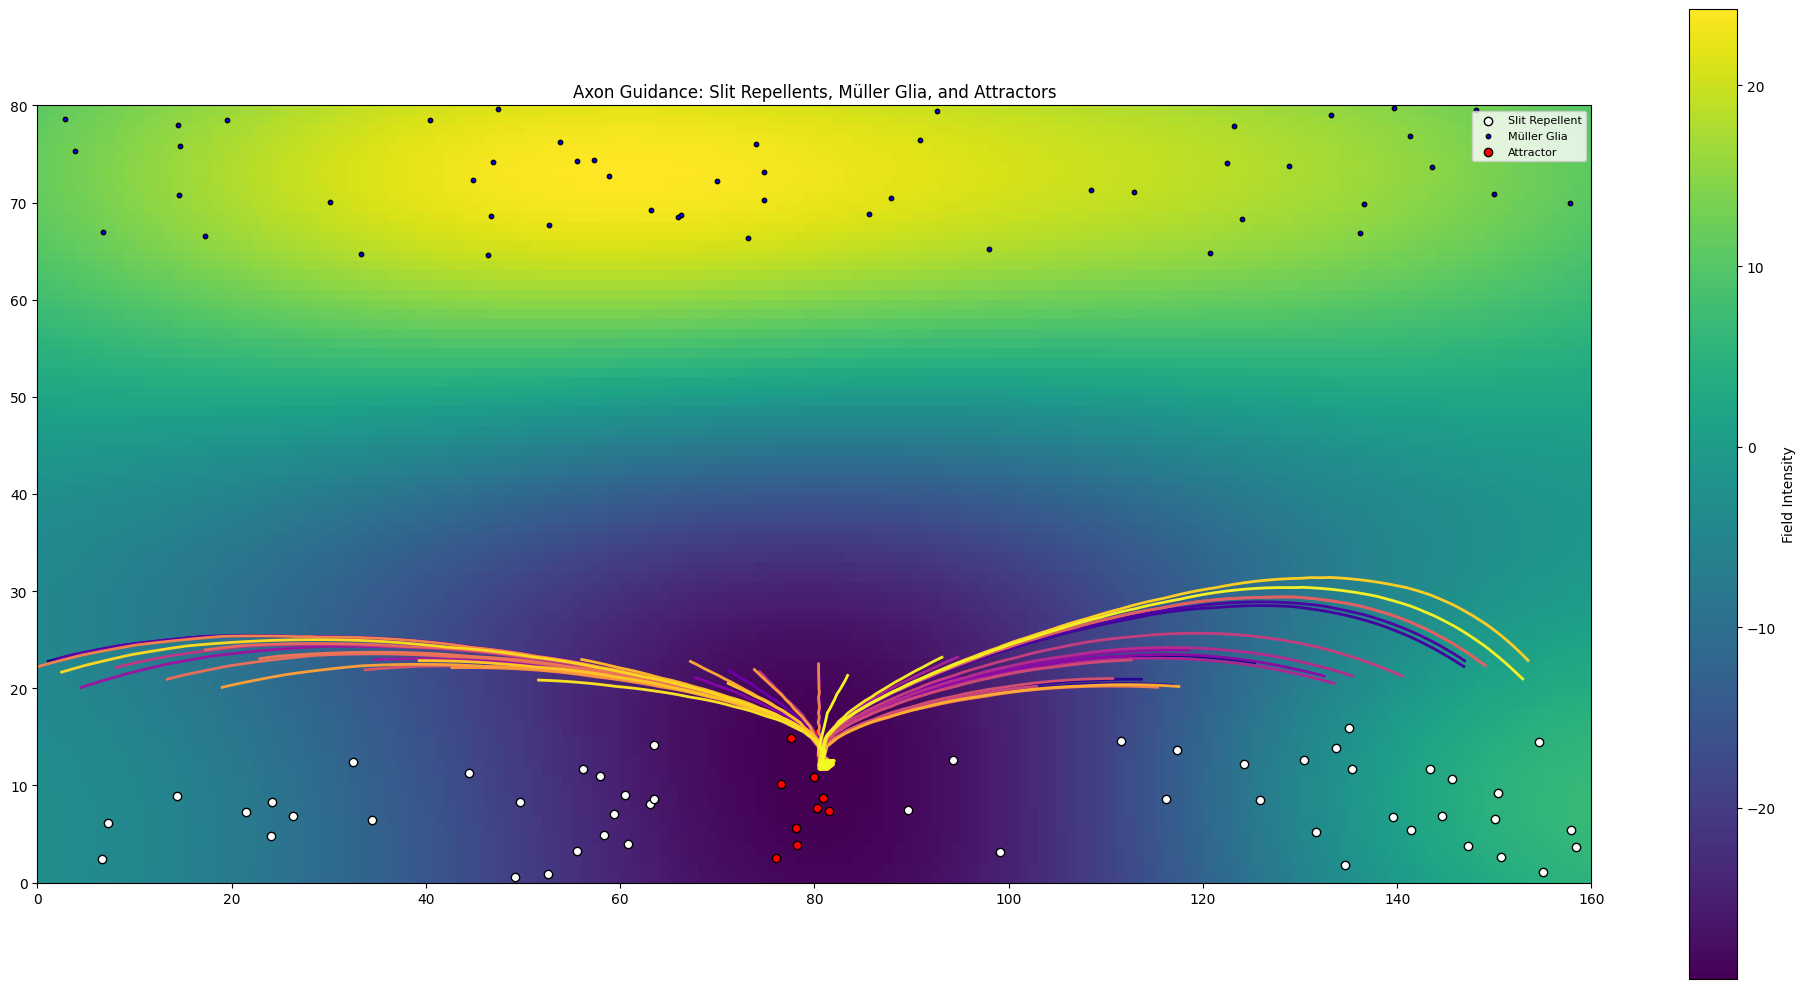

In [ ]:

# definitions
def main(
    grid_width,   # number of x-steps
    grid_height,   # number of y-steps

    num_neurons,
    num_amacrine_repellents,
    num_muller_repellents,
    num_attractors,

    sigma_amacrine,
    sigma_muller,
    sigma_attractor,

    amacrine_strength,
    muller_strength,
    attractor_strength,

    max_steps,
    include_plot=True
):
    """
    Main function runs a simulation
    """
    step_size = 1.0 / max(grid_width, grid_height)

    # Grid setup
    x = np.linspace(0, 1, grid_width)
    y = np.linspace(0, 1, grid_height)
    x, y = np.meshgrid(x, y)

    # generate field (return total_field)
    total_field, amacrine_positions, repellent_positions_muller, attractor_positions = generate_field(
        num_amacrine_repellents=num_amacrine_repellents,
        num_muller_repellents=num_muller_repellents,
        num_attractors=num_attractors,

        sigma_amacrine=sigma_amacrine,
        sigma_muller=sigma_muller,
        sigma_attractor=sigma_attractor,
        
        amacrine_strength=amacrine_strength,
        muller_strength=muller_strength,
        attractor_strength=attractor_strength,

        x=x,
        y=y
    )
    
    # compute neuron trajectories and return ND array with them + a list of indexes for color coding
    all_trajectories = compute_neuron_trajectory(
        total_field=total_field,
        grid_width=grid_width,
        grid_height=grid_height,
        num_neurons=num_neurons,
        step_size=step_size,
        max_steps=max_steps
    )
    
    # Generate a plot
    if include_plot:
        # use AXIS where you would use PLT in original code
        fig, axis = plot_field(total_field=total_field, grid_height=grid_height, grid_width=grid_width)
        axis = plot_neurons(all_trajectories=all_trajectories, axis=axis, grid_width=grid_width, grid_height=grid_height, num_neurons=num_neurons)
        axis = plot_atr_rep(
            axis=axis,
            grid_width=grid_width,
            grid_height=grid_height,
            amacrine_positions=amacrine_positions,
            repellent_positions_muller=repellent_positions_muller,
            attractor_positions=attractor_positions
        )
        
        plt.title("Axon Guidance: Slit Repellents, Müller Glia, and Attractors")
        plt.legend(loc='upper right', fontsize=8)
        plt.tight_layout()
        plt.show()
    
    return all_trajectories

def generate_field(
    num_amacrine_repellents,
    num_muller_repellents,
    num_attractors,

    sigma_amacrine,
    sigma_muller,
    sigma_attractor,
    
    amacrine_strength,
    muller_strength,
    attractor_strength,

    x,
    y
):
    # --- Generate field components separately ---

    # 1. Amacrine repellent field
    amacrine_positions = [
        (np.random.uniform(0.0, 0.45) if np.random.rand() < 0.5 else np.random.uniform(0.55, 1.0), 
        np.random.uniform(0.0, 0.2)) 
        for _ in range(num_amacrine_repellents)
    ]
    amacrine_field = np.zeros_like(x)

    for rx, ry in amacrine_positions:
        amacrine_field += amacrine_strength * np.exp(-((x - rx)**2 + (y - ry)**2) / (2 * sigma_amacrine**2))

    # 2. Müller glia repellent field
    repellent_positions_muller = [
        (np.random.uniform(0, 1), np.random.uniform(0.8, 1)) for _ in range(num_muller_repellents)
    ]
    muller_field = np.zeros_like(x)
    for rx, ry in repellent_positions_muller:
        muller_field += muller_strength * np.exp(-((x - rx)**2 + (y - ry)**2) / (2 * sigma_muller**2))

    # 3. Attractor field (optic disc)
    attractor_positions = [
        (np.random.uniform(0.475, 0.525), np.random.uniform(0.0, 0.2)) for _ in range(num_attractors)
    ]
    attractor_field = np.zeros_like(x)
    for ax, ay in attractor_positions:
        attractor_field -= attractor_strength * np.exp(-((x - ax)**2 + (y - ay)**2) / (2 * sigma_attractor**2))

    # --- Combine all fields ---
    total_field = amacrine_field + muller_field + attractor_field

    return total_field, amacrine_positions, repellent_positions_muller, attractor_positions

def compute_neuron_trajectory(
        total_field,
        grid_width,
        grid_height,
        num_neurons,
        step_size,
        max_steps
    ):
    # --- Compute field gradient ---
    grad_y, grad_x = np.gradient(total_field)

    # --- Neuron starting positions ---
    starting_positions = [
        (np.random.uniform(0, 1), np.random.uniform(0.25, 0.3)) for _ in range(num_neurons)
    ]

        # --- Simulate each neuron and save trajectories of---

    all_trajectories = {}
    for idx, start_pos in enumerate(starting_positions):
        fpos = np.array(start_pos, dtype=float)
        trajectory = []

        for _ in range(max_steps):
            trajectory.append(fpos.copy())
            i = int(fpos[1] * (grid_height - 1))
            j = int(fpos[0] * (grid_width - 1))
            if i < 0 or i >= grid_height or j < 0 or j >= grid_width:
                break
            direction = np.array([grad_x[i, j], grad_y[i, j]])
            norm = np.linalg.norm(direction)
            if norm == 0: # If gradient at a point is 0 the neuron should take a random step to mimic real cell behaviour
                random_direction = np.random.randn(2)
                random_direction /= np.linalg.norm(random_direction)
                fpos += step_size * random_direction
            else:
                fpos -= step_size * direction / norm
            
        trajectory = np.array(trajectory)
        all_trajectories[idx] = trajectory

    return all_trajectories

def plot_field(total_field, grid_height, grid_width):
    """
       
    """
    fig, axis = plt.subplots()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    cax = axis.imshow(total_field, cmap='viridis', origin='lower', extent=[0, grid_width, 0, grid_height])
    fig.colorbar(cax, label='Field Intensity')

    return fig, axis

def plot_neurons(all_trajectories, axis, grid_width, grid_height, num_neurons):

    colors = plt.cm.plasma(np.linspace(0, 1, num_neurons))
    for idx, trajectory in all_trajectories.items():
        axis.plot(trajectory[:, 0] * grid_width, trajectory[:, 1] * grid_height, color=colors[idx], linewidth=2)
    
    return axis
    
def plot_atr_rep(axis, grid_width, grid_height, amacrine_positions, repellent_positions_muller, attractor_positions):
    # --- Visual markers ---
    for rx, ry in amacrine_positions:
        axis.scatter(rx * grid_width, ry * grid_height, color='white', edgecolor='black', label='Slit Repellent' if rx == amacrine_positions[0][0] else "")

    for rx, ry in repellent_positions_muller:
        axis.scatter(rx * grid_width, ry * grid_height, color='blue', edgecolor='black', s=10, label='Müller Glia' if rx == repellent_positions_muller[0][0] else "")

    for ax, ay in attractor_positions:
        axis.scatter(ax * grid_width, ay * grid_height, color='red', edgecolor='black', label='Attractor' if ax == attractor_positions[0][0] else "")
    
    return axis

# this if clause stops the code from being executed when imported in another file
if __name__ == "__main__":

    main(
        grid_width = 160,   # number of x-steps
        grid_height = 80,   # number of y-steps
        num_neurons = 50,
        num_amacrine_repellents = 50,
        num_muller_repellents = 50,
        num_attractors = 10,
        sigma_amacrine = 0.2,
        sigma_muller = 0.2,
        sigma_attractor = 0.3,
        amacrine_strength = 1.0,
        muller_strength = 1.0,
        attractor_strength = 5.0,
        max_steps = 100
    )



Let's run some tests?

## No attractors test

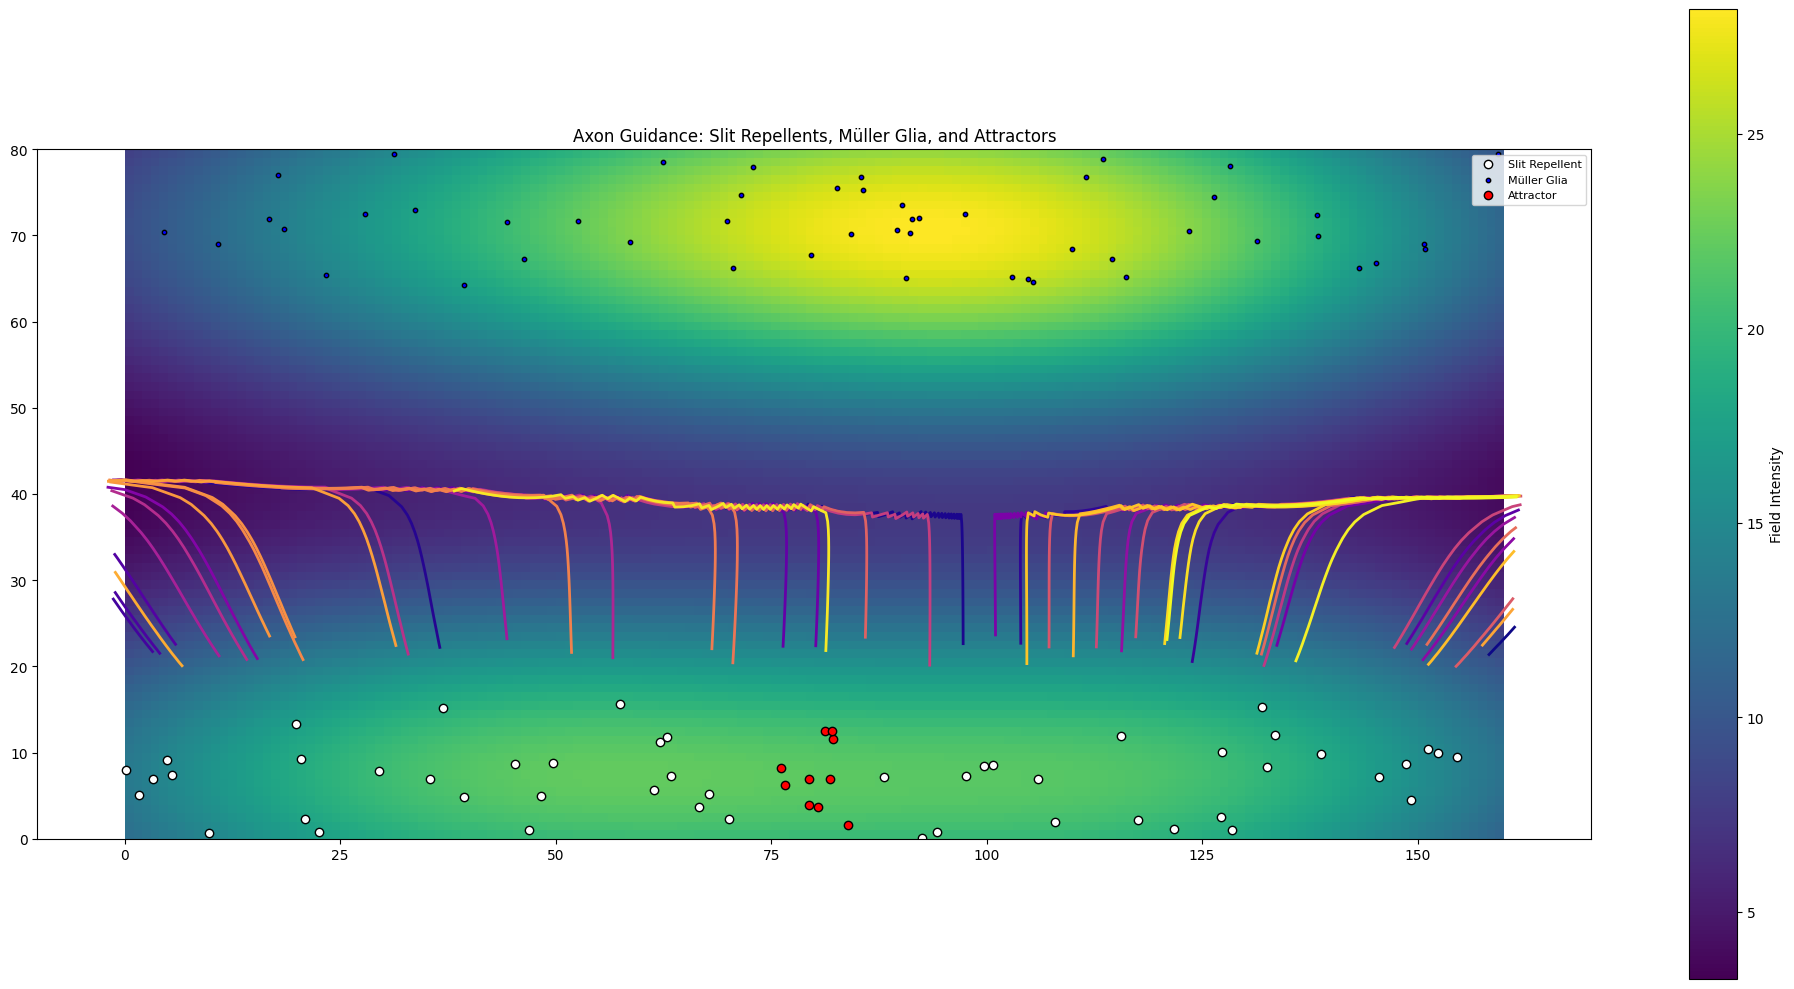

In [2]:
#No attractors test - attractor strength = 0

main(
        grid_width = 160,   # number of x-steps
        grid_height = 80,   # number of y-steps
        num_neurons = 50,
        num_amacrine_repellents = 50,
        num_muller_repellents = 50,
        num_attractors = 10,
        sigma_amacrine = 0.2,
        sigma_muller = 0.2,
        sigma_attractor = 0.3,
        amacrine_strength = 1.0,
        muller_strength = 1.0,
        attractor_strength = 0,
        max_steps = 100
    )

## No muller glia test

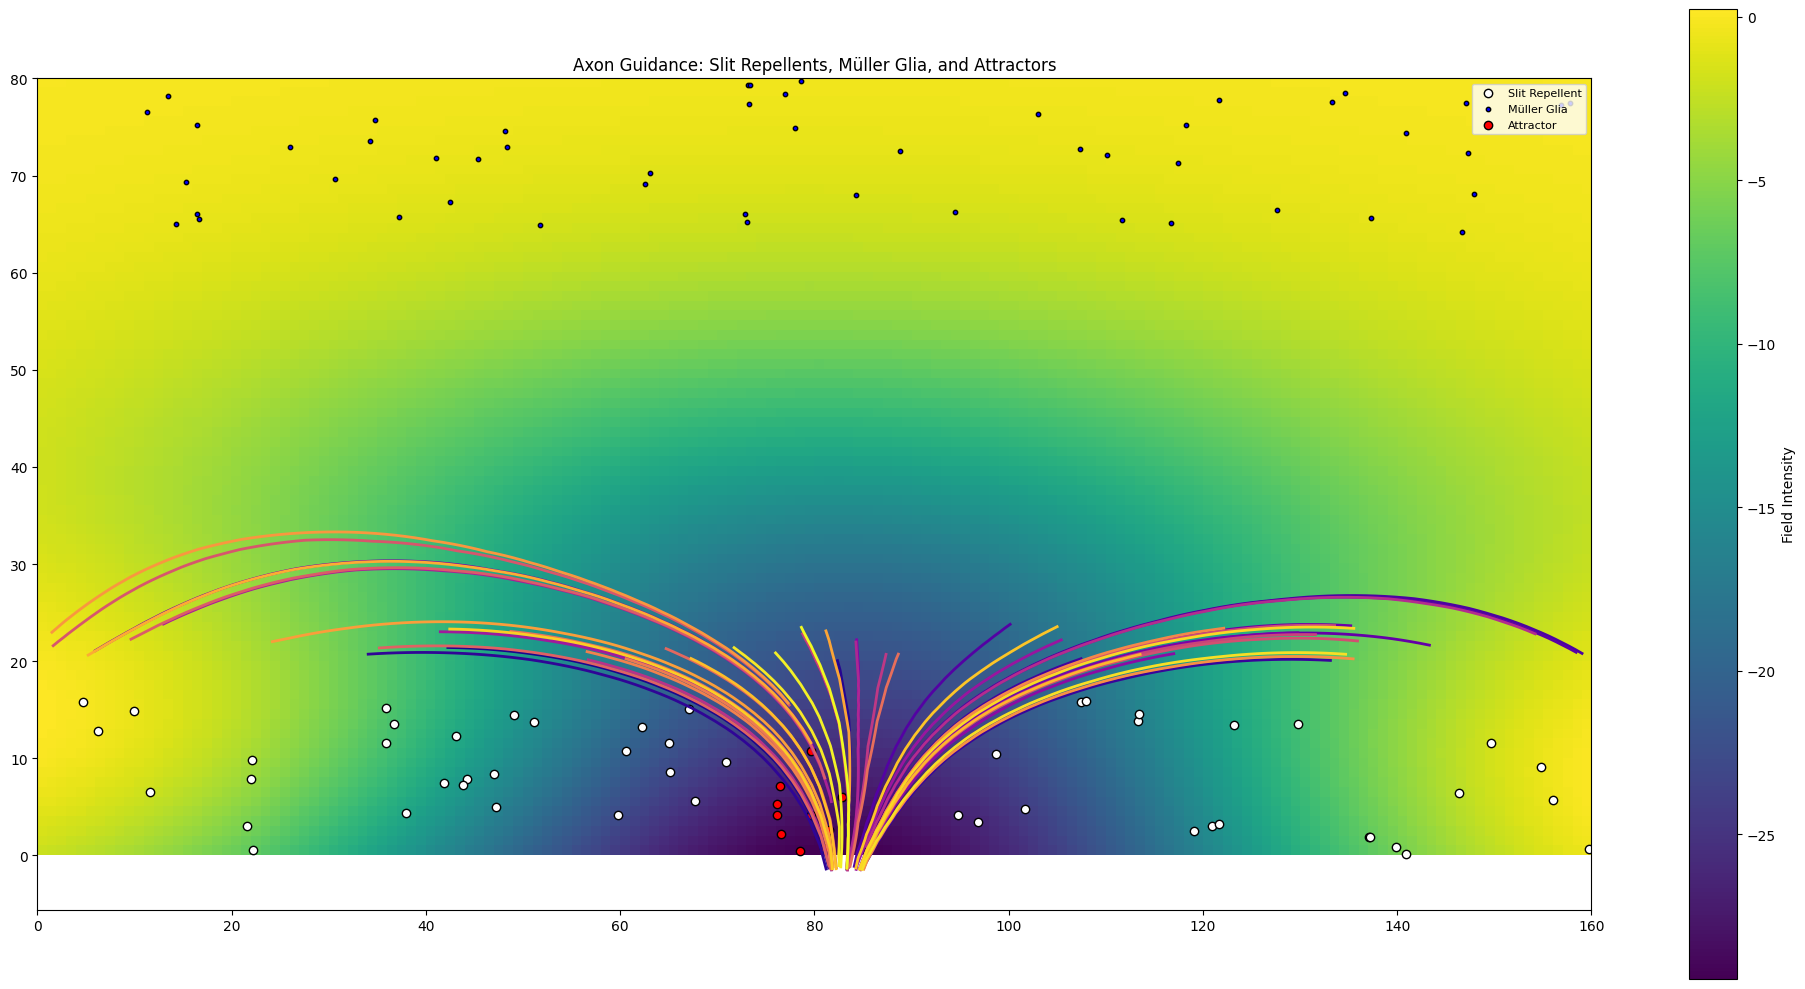

{0: array([[ 0.49543155,  0.27413785],
        [ 0.497089  ,  0.26811163],
        [ 0.49846105,  0.26201409],
        [ 0.4998928 ,  0.25593029],
        [ 0.50132454,  0.24984649],
        [ 0.5028041 ,  0.24377415],
        [ 0.50428365,  0.2377018 ],
        [ 0.50548562,  0.23156846],
        [ 0.50668759,  0.22543513],
        [ 0.50790774,  0.21930539],
        [ 0.5091279 ,  0.21317565],
        [ 0.51035531,  0.20704736],
        [ 0.51125375,  0.20086227],
        [ 0.51214698,  0.19467643],
        [ 0.5130402 ,  0.18849059],
        [ 0.51392025,  0.18230286],
        [ 0.51480031,  0.17611513],
        [ 0.51566033,  0.16992458],
        [ 0.51652035,  0.16373403],
        [ 0.51700956,  0.15750321],
        [ 0.51749877,  0.15127238],
        [ 0.5179564 ,  0.14503916],
        [ 0.51841403,  0.13880594],
        [ 0.51883614,  0.13257021],
        [ 0.51925824,  0.12633448],
        [ 0.51964142,  0.12009623],
        [ 0.52002459,  0.11385799],
        [ 0.52036574,  0.

In [4]:
# No muller glia test: - doesn't appear to influence the model

main(
        grid_width = 160,   # number of x-steps
        grid_height = 80,   # number of y-steps
        num_neurons = 50,
        num_amacrine_repellents = 50,
        num_muller_repellents = 50,
        num_attractors = 10,
        sigma_amacrine = 0.2,
        sigma_muller = 0.2,
        sigma_attractor = 0.3,
        amacrine_strength = 1.0,
        muller_strength = 0, 
        attractor_strength = 5.0,
        max_steps = 100
    )

## No muller and no attractor

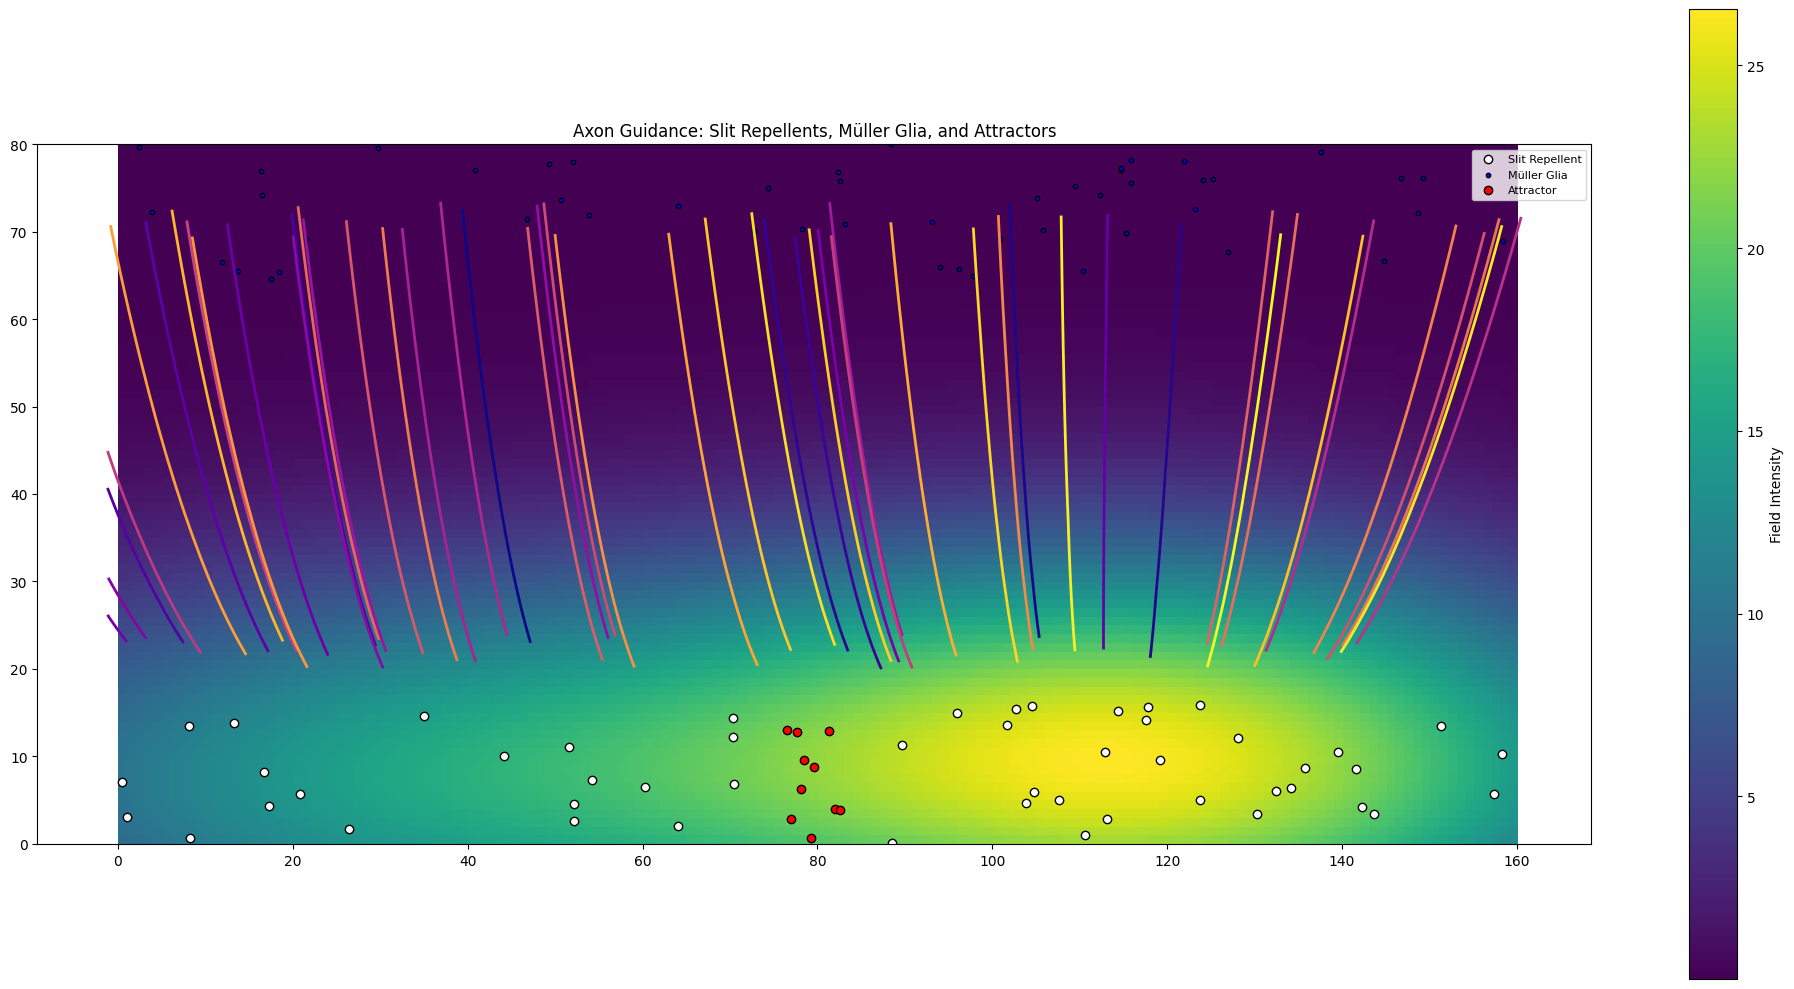

In [20]:
# No muller and no attractor
main(
        grid_width = 160,   # number of x-steps
        grid_height = 80,   # number of y-steps
        num_neurons = 50,
        num_amacrine_repellents = 50,
        num_muller_repellents = 50,
        num_attractors = 10,
        sigma_amacrine = 0.2,
        sigma_muller = 0.2,
        sigma_attractor = 0.3,
        amacrine_strength = 1.0,
        muller_strength = 0,
        attractor_strength = 0,
        max_steps = 100
    )

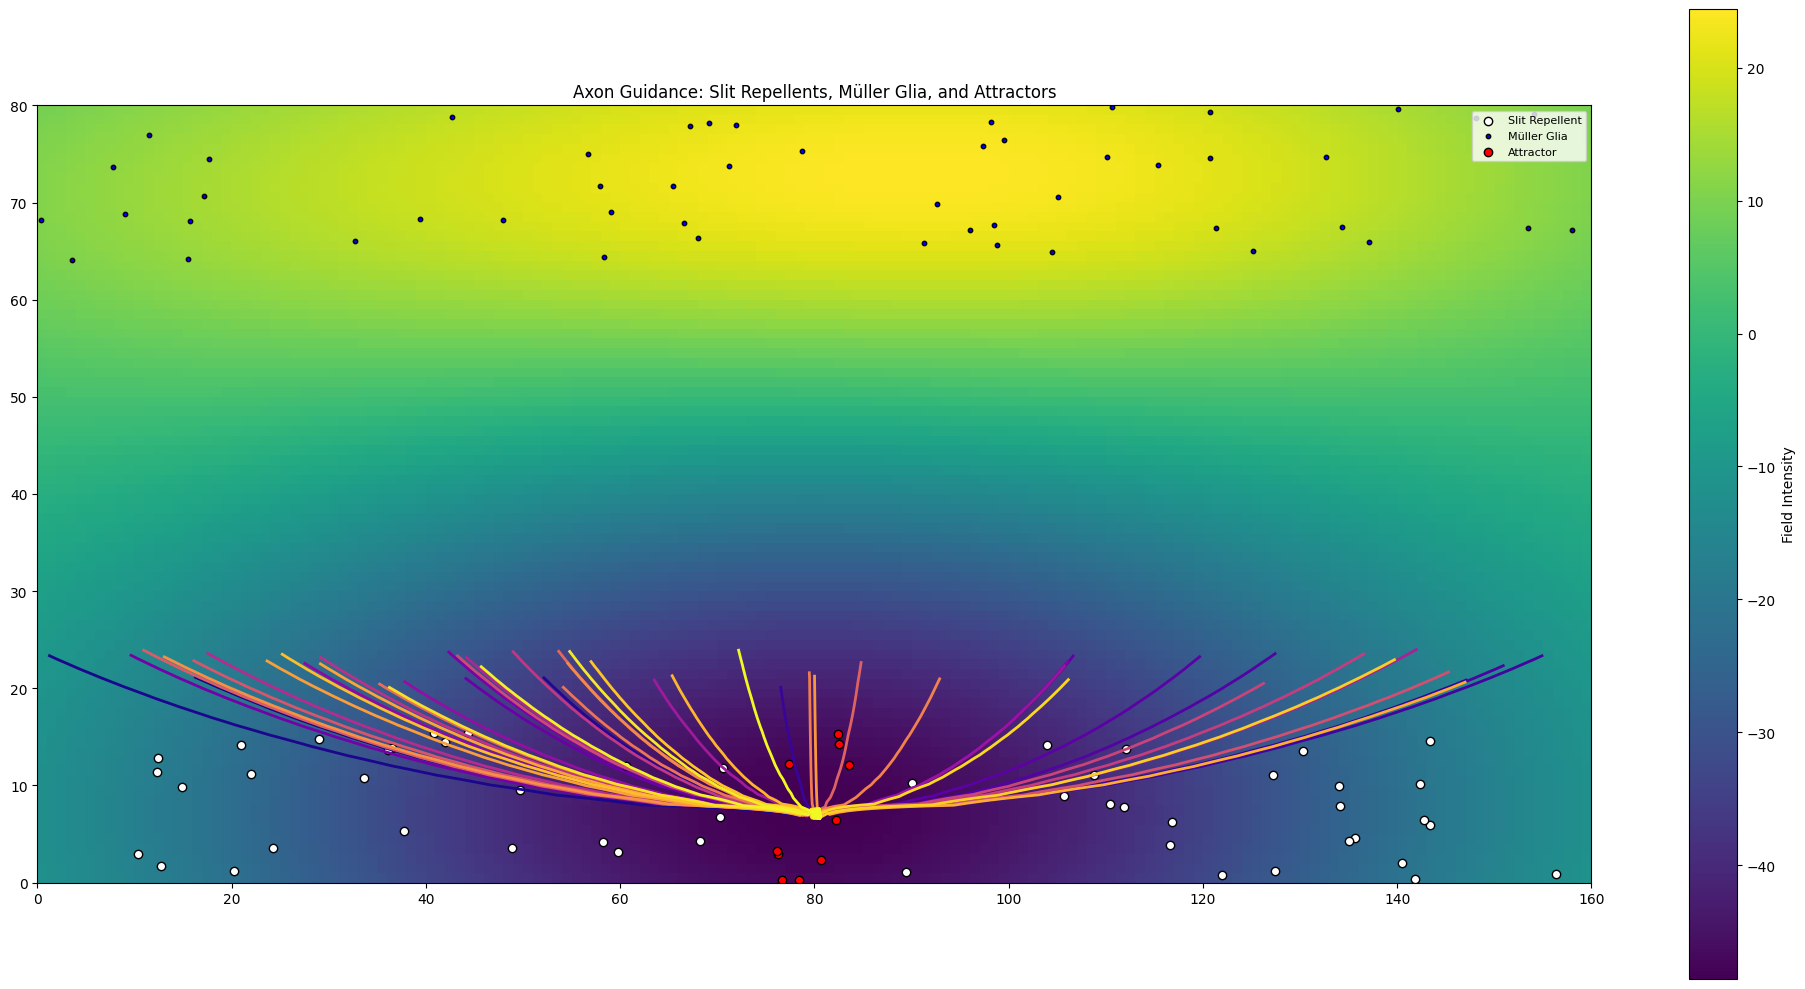

In [21]:
# No amacrine
main(
        grid_width = 160,   # number of x-steps
        grid_height = 80,   # number of y-steps
        num_neurons = 50,
        num_amacrine_repellents = 50,
        num_muller_repellents = 50,
        num_attractors = 10,
        sigma_amacrine = 0.2,
        sigma_muller = 0.2,
        sigma_attractor = 0.3,
        amacrine_strength = 0,
        muller_strength = 1.0,
        attractor_strength = 5.0,
        max_steps = 100
    )

## plot axon start location x vs trajectory start y - max y


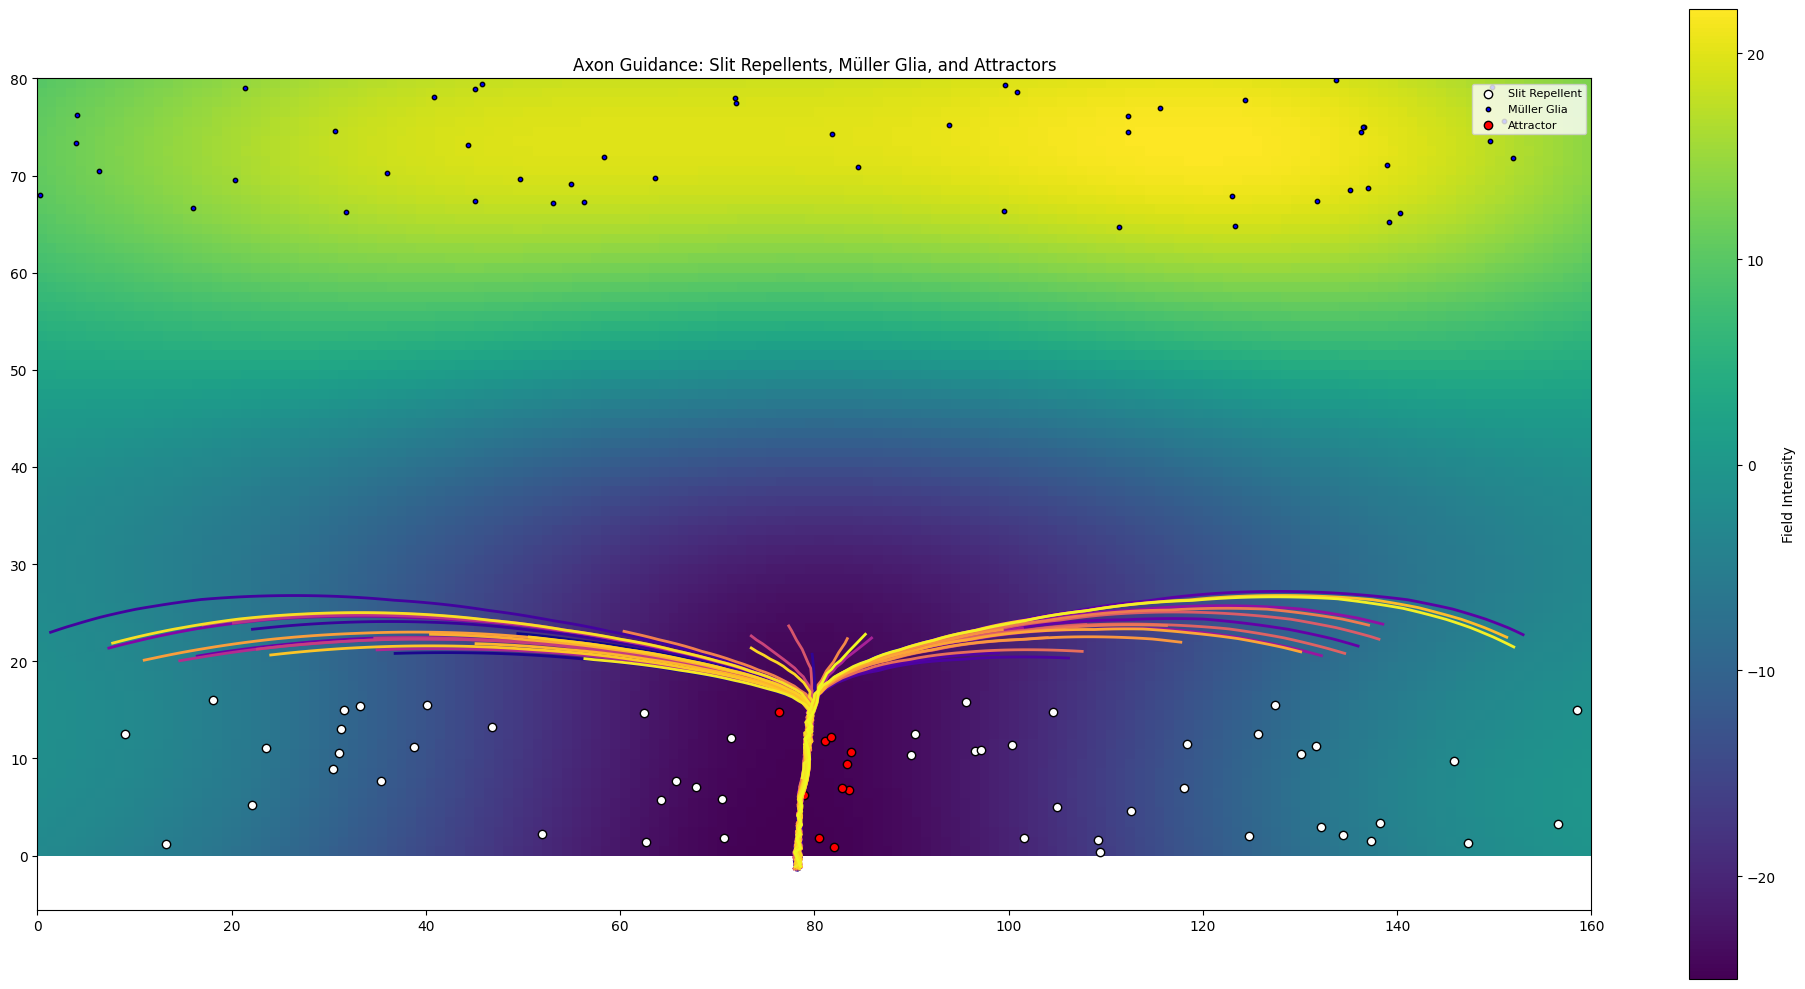

In [4]:
computed_trajectories = main(
        grid_width = 160,   # number of x-steps
        grid_height = 80,   # number of y-steps
        num_neurons = 50,
        num_amacrine_repellents = 50,
        num_muller_repellents = 50,
        num_attractors = 10,
        sigma_amacrine = 0.2,
        sigma_muller = 0.2,
        sigma_attractor = 0.3,
        amacrine_strength = 1.0,
        muller_strength = 1.0,
        attractor_strength = 5.0,
        max_steps = 100
    )

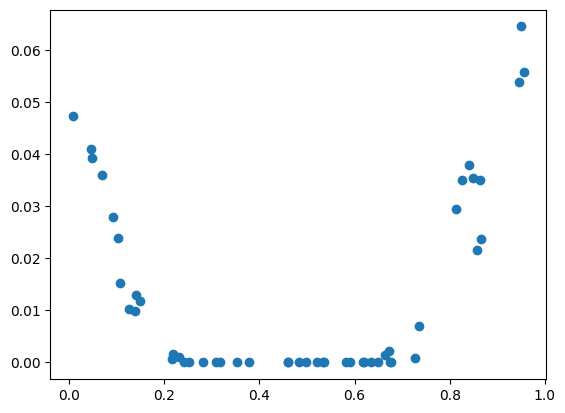

In [5]:
all_neurons_start_x = []
all_neurons_y_difference = []

for key in computed_trajectories:
    
    # max_y
    single_neuron_ys = computed_trajectories[key][:, 1] #extraxts y column
    max_y= single_neuron_ys.max()

    start_x = computed_trajectories[key][0,0]
    all_neurons_start_x.append(start_x)

    start_y = computed_trajectories[key][0,1]

    y_difference = max_y - start_y
    all_neurons_y_difference.append(y_difference)

plt.scatter(all_neurons_start_x, all_neurons_y_difference)
plt.show()





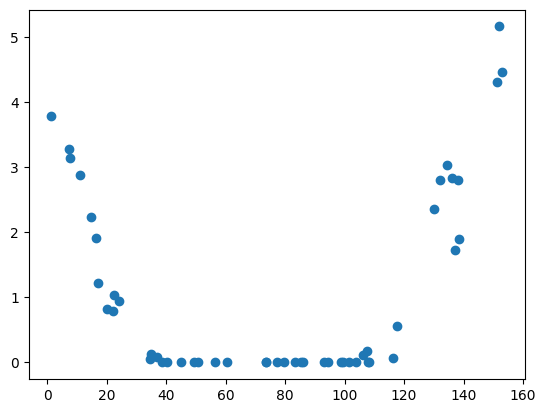

In [6]:
all_neurons_start_x_scaled = [160*x for x in all_neurons_start_x]
all_neurons_y_difference_scaled = [80*x for x in all_neurons_y_difference]
plt.scatter(all_neurons_start_x_scaled, all_neurons_y_difference_scaled)


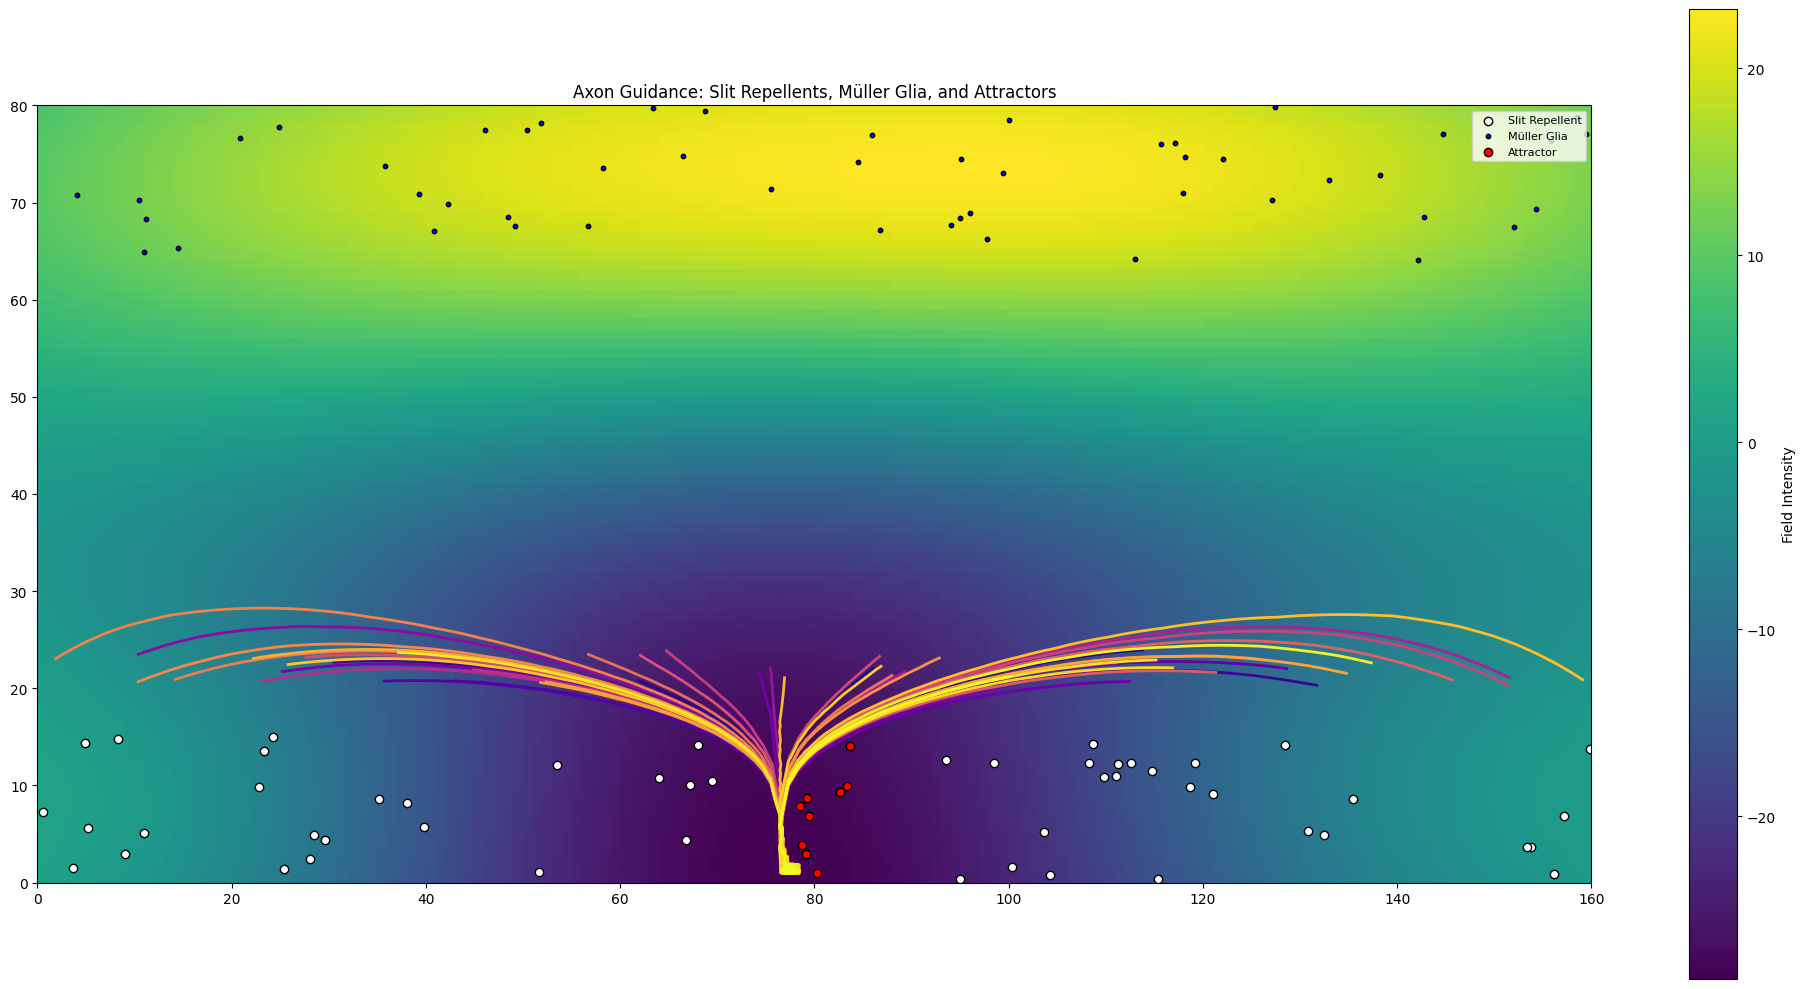

: 

In [ ]:

def main(
    grid_width,   # number of x-steps
    grid_height,   # number of y-steps

    num_neurons,
    num_amacrine_repellents,
    num_muller_repellents,
    num_attractors,

    sigma_amacrine,
    sigma_muller,
    sigma_attractor,

    amacrine_strength,
    muller_strength,
    attractor_strength,

    max_steps,
    include_plot=True
):
    """
    Main function runs a simulation
    """
    step_size = 1.0 / max(grid_width, grid_height)

    # Grid setup
    x = np.linspace(0, 1, grid_width)
    y = np.linspace(0, 1, grid_height)
    x, y = np.meshgrid(x, y)

    # generate field (return total_field)
    total_field, amacrine_positions, repellent_positions_muller, attractor_positions = generate_field(
        num_amacrine_repellents=num_amacrine_repellents,
        num_muller_repellents=num_muller_repellents,
        num_attractors=num_attractors,

        sigma_amacrine=sigma_amacrine,
        sigma_muller=sigma_muller,
        sigma_attractor=sigma_attractor,
        
        amacrine_strength=amacrine_strength,
        muller_strength=muller_strength,
        attractor_strength=attractor_strength,

        x=x,
        y=y
    )
    
    # compute neuron trajectories and return ND array with them + a list of indexes for color coding
    all_trajectories = compute_neuron_trajectory(
        total_field=total_field,
        grid_width=grid_width,
        grid_height=grid_height,
        num_neurons=num_neurons,
        step_size=step_size,
        max_steps=max_steps
    )
    
    # Generate a plot
    if include_plot:
        # use AXIS where you would use PLT in original code
        fig, axis = plot_field(total_field=total_field, grid_height=grid_height, grid_width=grid_width)
        axis = plot_neurons(all_trajectories=all_trajectories, axis=axis, grid_width=grid_width, grid_height=grid_height, num_neurons=num_neurons)
        axis = plot_atr_rep(
            axis=axis,
            grid_width=grid_width,
            grid_height=grid_height,
            amacrine_positions=amacrine_positions,
            repellent_positions_muller=repellent_positions_muller,
            attractor_positions=attractor_positions
        )
        
        plt.title("Axon Guidance: Slit Repellents, Müller Glia, and Attractors")
        plt.legend(loc='upper right', fontsize=8)
        plt.tight_layout()
        plt.show()
    
    return all_trajectories

def generate_amacrine_pos(num_amacrine_repellents):
    amacrine_positions = [
        (np.random.uniform(0.0, 0.45) if np.random.rand() < 0.5 else np.random.uniform(0.55, 1.0), 
        np.random.uniform(0.0, 0.2)) 
        for _ in range(num_amacrine_repellents)
    ]
    return amacrine_positions
 
#def generate_muller_pos
#def generate_neuron_pos

def generate_field(
    num_muller_repellents,
    num_attractors,

    sigma_amacrine,
    sigma_muller,
    sigma_attractor,
    
    amacrine_strength,
    muller_strength,
    attractor_strength,

    x,
    y,
    amacrine_positions,
):
    # --- Generate field components separately ---

    # 1. Amacrine repellent field
    amacrine_field = np.zeros_like(x)

    for rx, ry in amacrine_positions:
        amacrine_field += amacrine_strength * np.exp(-((x - rx)**2 + (y - ry)**2) / (2 * sigma_amacrine**2))

    # 2. Müller glia repellent field
    repellent_positions_muller = [
        (np.random.uniform(0, 1), np.random.uniform(0.8, 1)) for _ in range(num_muller_repellents)
    ]
    muller_field = np.zeros_like(x)
    for rx, ry in repellent_positions_muller:
        muller_field += muller_strength * np.exp(-((x - rx)**2 + (y - ry)**2) / (2 * sigma_muller**2))

    # 3. Attractor field (optic disc)
    attractor_positions = [
        (np.random.uniform(0.475, 0.525), np.random.uniform(0.0, 0.2)) for _ in range(num_attractors)
    ]
    attractor_field = np.zeros_like(x)
    for ax, ay in attractor_positions:
        attractor_field -= attractor_strength * np.exp(-((x - ax)**2 + (y - ay)**2) / (2 * sigma_attractor**2))

    # --- Combine all fields ---
    total_field = amacrine_field + muller_field + attractor_field

    return total_field, amacrine_positions, repellent_positions_muller, attractor_positions

def compute_neuron_trajectory(
        total_field,
        grid_width,
        grid_height,
        num_neurons,
        step_size,
        max_steps
    ):
    # --- Compute field gradient ---
    grad_y, grad_x = np.gradient(total_field)

    # --- Neuron starting positions ---
    starting_positions = [
        (np.random.uniform(0, 1), np.random.uniform(0.25, 0.3)) for _ in range(num_neurons)
    ]

        # --- Simulate each neuron and save trajectories of---

    all_trajectories = {}
    for idx, start_pos in enumerate(starting_positions):
        fpos = np.array(start_pos, dtype=float)
        trajectory = []

        for _ in range(max_steps):
            trajectory.append(fpos.copy())
            i = int(fpos[1] * (grid_height - 1))
            j = int(fpos[0] * (grid_width - 1))
            if i < 0 or i >= grid_height or j < 0 or j >= grid_width:
                break
            direction = np.array([grad_x[i, j], grad_y[i, j]])
            norm = np.linalg.norm(direction)
            if norm == 0: # If gradient at a point is 0 the neuron should take a random step to mimic real cell behaviour
                random_direction = np.random.randn(2)
                random_direction /= np.linalg.norm(random_direction)
                fpos += step_size * random_direction
            else:
                fpos -= step_size * direction / norm
            
        trajectory = np.array(trajectory)
        all_trajectories[idx] = trajectory

    return all_trajectories

def plot_field(total_field, grid_height, grid_width):
    """
       
    """
    fig, axis = plt.subplots()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    cax = axis.imshow(total_field, cmap='viridis', origin='lower', extent=[0, grid_width, 0, grid_height])
    fig.colorbar(cax, label='Field Intensity')

    return fig, axis

def plot_neurons(all_trajectories, axis, grid_width, grid_height, num_neurons):

    colors = plt.cm.plasma(np.linspace(0, 1, num_neurons))
    for idx, trajectory in all_trajectories.items():
        axis.plot(trajectory[:, 0] * grid_width, trajectory[:, 1] * grid_height, color=colors[idx], linewidth=2)
    
    return axis
    
def plot_atr_rep(axis, grid_width, grid_height, amacrine_positions, repellent_positions_muller, attractor_positions):
    # --- Visual markers ---
    for rx, ry in amacrine_positions:
        axis.scatter(rx * grid_width, ry * grid_height, color='white', edgecolor='black', label='Slit Repellent' if rx == amacrine_positions[0][0] else "")

    for rx, ry in repellent_positions_muller:
        axis.scatter(rx * grid_width, ry * grid_height, color='blue', edgecolor='black', s=10, label='Müller Glia' if rx == repellent_positions_muller[0][0] else "")

    for ax, ay in attractor_positions:
        axis.scatter(ax * grid_width, ay * grid_height, color='red', edgecolor='black', label='Attractor' if ax == attractor_positions[0][0] else "")
    
    return axis

# this if clause stops the code from being executed when imported in another file
if __name__ == "__main__":

    main(
        grid_width = 160,   
        grid_height = 80, 
        num_neurons = 50,
        num_amacrine_repellents = 50,
        num_muller_repellents = 50,
        num_attractors = 10,
        sigma_amacrine = 0.2,
        sigma_muller = 0.2,
        sigma_attractor = 0.3,
        amacrine_strength = 1.0,
        muller_strength = 1.0,
        attractor_strength = 5.0,
        max_steps = 100
    )

